In [2]:
import random
import matplotlib.pyplot as plt

import torch
from omegaconf import OmegaConf
import models

from torch import nn
from utils import seed_all
from data import get_field

from huggingface_hub import hf_hub_download

device = 'cuda:0'

def _d(file):
    return hf_hub_download(
        repo_id='ML2/meent-sample-data', 
        filename=file, 
        repo_type='dataset',
    )

## Download pretrained weights and test dataset(This takes a while)

In [3]:
ckpt_path = _d('fno/model-final.pt')
test_ds_path = _d('fno/1000-50-4-test-ds.pt')
config_path = _d('fno/.hydra/config.yaml')

model-final.pt:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

1000-50-4-test-ds.pt:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

fno/.hydra/config.yaml:   0%|          | 0.00/731 [00:00<?, ?B/s]

In [4]:
wavelength = 1000
deflected_angle = 50

cfg = OmegaConf.load(config_path)

model = getattr(models, cfg.model)(**cfg.model_config)
model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cpu')))
model.eval()

seed_all(cfg.seed)

test_ds = torch.load(test_ds_path)

# Electric field prediction

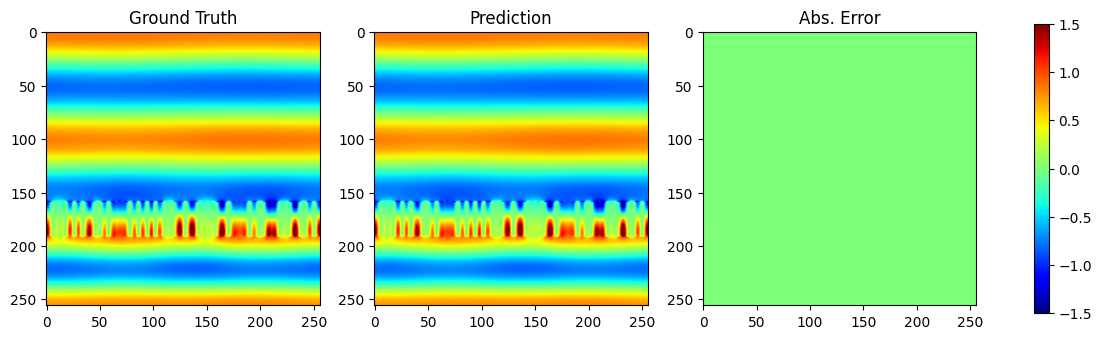

In [5]:
model = model.to(device)
idx = random.randint(0, 2000)
with torch.no_grad():
    out = model(x=test_ds[idx]['x'].unsqueeze(0).to(device)).detach().cpu()
y = test_ds[idx]['y'].unsqueeze(0)

v = 1.5
vmin = -v
vmax = v

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(out[0][0], cmap='jet', vmin=vmin, vmax=vmax)
axes[0].set_title('Ground Truth')

axes[1].imshow(y[0][0], cmap='jet', vmin=vmin, vmax=vmax)
axes[1].set_title('Prediction')

error = (y[0][0]-out[0][0]).abs()
im = axes[2].imshow(error, cmap='jet', vmin=vmin, vmax=vmax)
axes[2].set_title('Abs. Error')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.25)

plt.show()

# Super resolution

In [6]:
f = nn.Upsample(scale_factor=2., mode='nearest')
upscaled_x = f(test_ds[0]['x'].unsqueeze(0))[0, 0]
upscaled_x.shape

torch.Size([512, 512])

In [7]:
idx = int(upscaled_x.shape[0]*(5/8))
pattern_x = upscaled_x[idx]
upscaled_y = get_field(
    pattern_x, 
    wavelength=wavelength, deflected_angle=deflected_angle, 
    field_res=(512, 1, 64)
)
upscaled_y.shape

(512, 512)

## Ground truth

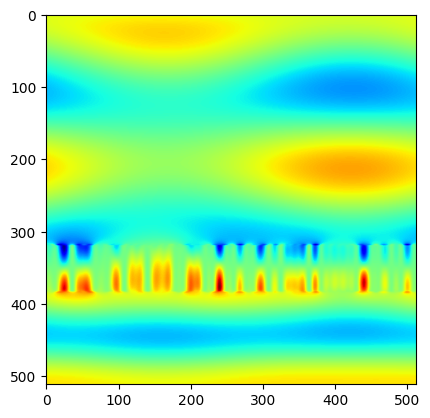

In [8]:
plt.imshow(upscaled_y.real, cmap='jet')

## FNO Prediction

In [9]:
pred_y = model(x=upscaled_x.unsqueeze(0).unsqueeze(0).to(device))
pred_y.shape

torch.Size([1, 2, 512, 512])

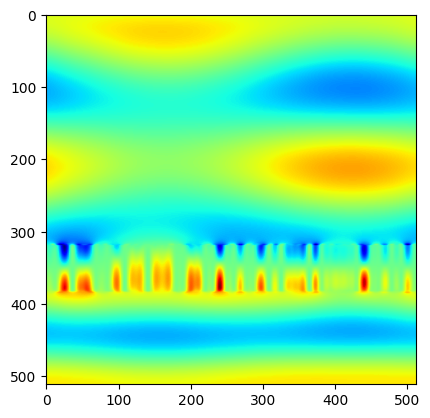

In [10]:
plt.imshow(pred_y[0, 0].cpu().detach(), cmap='jet')